In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import OutputEncoderCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'


/home/qi/Workspace/github/neuraloperator/neuralop/models/base_model.py:21: UserWarning: Creating a subclass of BaseModel FNO1d with no name, initializing with FNO1d.
  warnings.warn(f'Creating a subclass of BaseModel {cls.__name__} with no name, initializing with {cls.__name__}.')
/home/qi/Workspace/github/neuraloperator/neuralop/models/base_model.py:21: UserWarning: Creating a subclass of BaseModel FNO2d with no name, initializing with FNO2d.
  warnings.warn(f'Creating a subclass of BaseModel {cls.__name__} with no name, initializing with {cls.__name__}.')
/home/qi/Workspace/github/neuraloperator/neuralop/models/base_model.py:21: UserWarning: Creating a subclass of BaseModel FNO3d with no name, initializing with FNO3d.
  warnings.warn(f'Creating a subclass of BaseModel {cls.__name__} with no name, initializing with {cls.__name__}.')
/home/qi/Workspace/github/neuraloperator/neuralop/models/base_model.py:21: UserWarning: Creating a subclass of BaseModel TFNO with no name, initializing w

In [2]:
# %%
# Loading the Navier-Stokes dataset in 128x128 resolution
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)


UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


In [3]:
# %%
# We create a tensorized FNO model

model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Keyword argument in_channels not specified for model TFNO, using default=3.
Keyword argument out_channels not specified for model TFNO, using default=1.
Keyword argument lifting_channels not specified for model TFNO, using default=256.
Keyword argument n_layers not specified for model TFNO, using default=4.
Keyword argument output_scaling_factor not specified for model TFNO, using default=None.
Keyword argument max_n_modes not specified for model TFNO, using default=None.
Keyword argument fno_block_precision not specified for model TFNO, using default=full.
Keyword argument use_mlp not specified for model TFNO, using default=False.
Keyword argument mlp_dropout not specified for model TFNO, using default=0.
Keyword argument mlp_expansion not specified for model TFNO, using default=0.5.
Keyword argument non_linearity not specified for model TFNO, using default=<built-in function gelu>.
Keyword argument stabilizer not specified for model TFNO, using default=None.
Keyword argument norm not

In [4]:
# %%
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)



In [5]:
# %%
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}



In [6]:
# %%


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0): ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
        (1): ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
        (2): ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
        (3): ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32,

In [7]:
# %% 
# Create the trainer
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  callbacks=[OutputEncoderCallback(output_encoder)],             
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [8]:
# %%
# Actually train the model on our small Darcy-Flow dataset

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)



/tmp/ipykernel_71078/3359754389.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


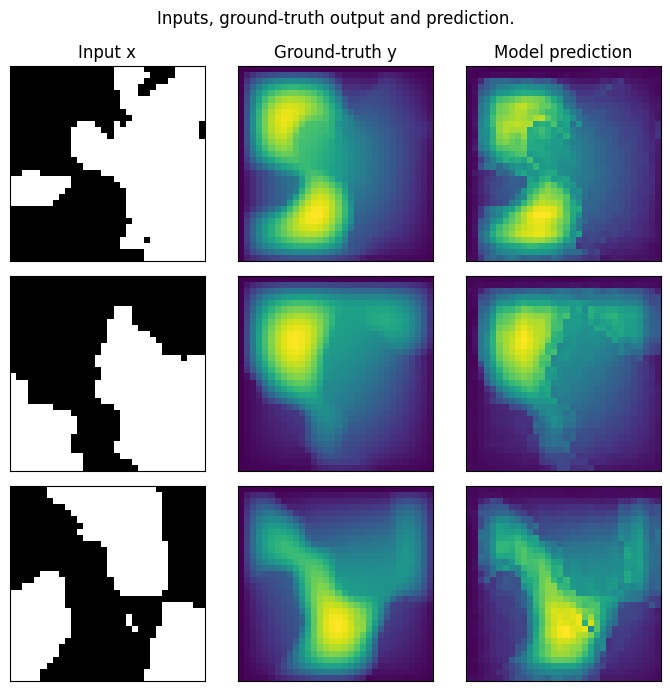

In [9]:
# %%
# Plot the prediction, and compare with the ground-truth 
# Note that we trained on a very small resolution for
# a very small number of epochs
# In practice, we would train at larger resolution, on many more samples.
# 
# However, for practicity, we created a minimal example that
# i) fits in just a few Mb of memory
# ii) can be trained quickly on CPU
#
# In practice we would train a Neural Operator on one or multiple GPUs

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()
